# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import seaborn as sns
from scipy import ndimage
from skimage.morphology import skeletonize
import geopandas as gpd
from shapely import geometry
import rasterio
from rasterio import features

%matplotlib inline

In [2]:
sns.set()
sns.set_palette('husl', 8)

# Create a flow direction grid from a raster

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [3]:
grid = Grid.from_raster('../data/n30w100_dir', data_name='dir')

In [4]:
grid.read_raster('../data/n30w100_con', data_name='dem')

# Specify flow direction values

In [5]:
         #N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Delineate catchment

In [6]:
# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')

In [7]:
# Clip the bounding box to the catchment
grid.clip_to('catch')

# Get flow accumulation

In [8]:
grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')

# Simplest way to burn DEM

Burn based on a raster, with a constant value for all channelized cells

In [9]:
# Set elevation change for burned cells
dz = 5.5

# Select cells with > 100 accumulation
mask = grid.view('acc') > 100

# Create a view onto the DEM array
dem = grid.view('dem', dtype=np.float64, nodata=np.nan)

# Subtract dz where accumulation is above the threshold
dem[mask] -= dz

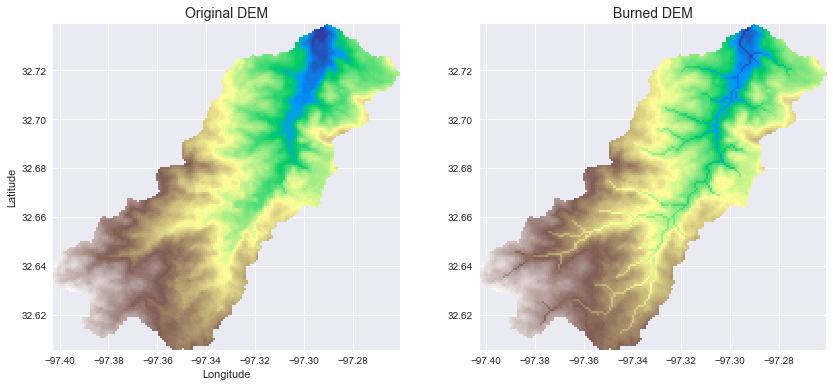

In [10]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].imshow(grid.view('dem', nodata=np.nan), cmap='terrain', zorder=1, extent=grid.extent)
ax[1].imshow(dem, cmap='terrain', zorder=1, extent=grid.extent)

ax[0].set_title('Original DEM', size=14)
ax[1].set_title('Burned DEM', size=14)

ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')
ax[0].set_xlabel('Longitude')

# Burn from a shapefile

Data from National Hydrography Dataset: https://nhd.usgs.gov/data.html

In [11]:
# Read shapefile
rivers = gpd.read_file('../../../Data/GIS/DFW_HUC/NHDFlowline.shp')

In [12]:
# Clip shapefile to catchment boundary
catchment_outline = rasterio.features.shapes(grid.mask.astype(np.uint8),
                                             mask=grid.mask, connectivity=4, transform=grid.affine)
coords = [np.asarray(shape[0]['coordinates'][0]) for shape in catchment_outline][0]
catchment_polygon = geometry.Polygon(coords)
rivers = rivers[rivers.within(catchment_polygon)]

In [13]:
# Rasterize river shapefile
river_raster = features.rasterize(rivers.geometry, out_shape=grid.shape,
                                  transform=grid.affine, all_touched=False)

In [14]:
# Skeletonize river raster
river_raster = skeletonize(river_raster).astype(np.uint8)

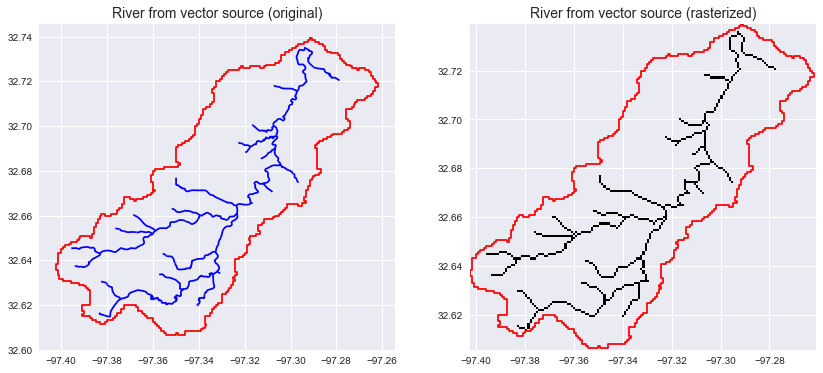

In [15]:
# Plot result
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(coords[:,0], coords[:,1], color='r')
rivers.plot(ax=ax[0], color='b')
ax[1].plot(coords[:,0], coords[:,1], color='r')
ax[1].imshow(np.where(river_raster, river_raster, np.nan), zorder=1, extent=grid.extent, cmap='bone')
ax[0].set_title('River from vector source (original)', size=14)
ax[1].set_title('River from vector source (rasterized)', size=14)

In [16]:
# Set elevation change for burned cells
dz = 5.5

# Create boolean mask based on rasterized river shapes
mask = river_raster.astype(bool)

# Create a view onto the DEM array
dem = grid.view('dem', dtype=np.float64, nodata=np.nan)

# Subtract dz where accumulation is above the threshold
dem[mask] -= dz

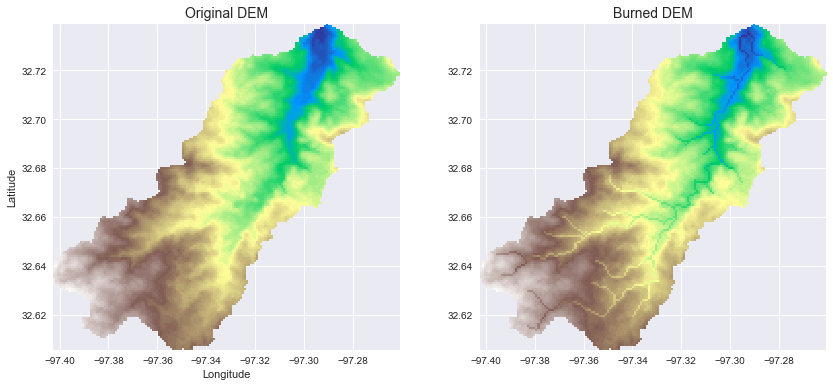

In [17]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].imshow(grid.view('dem', nodata=np.nan), cmap='terrain', zorder=1, extent=grid.extent)
ax[1].imshow(dem, cmap='terrain', zorder=1, extent=grid.extent)

ax[0].set_title('Original DEM', size=14)
ax[1].set_title('Burned DEM', size=14)

ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')
ax[0].set_xlabel('Longitude')

# Smooth transition using gaussian blur

In [18]:
# Blur mask using a gaussian filter
blurred_mask = ndimage.filters.gaussian_filter(mask.astype(np.float64), sigma=2.5)

# Set central channel to max to prevent pits
blurred_mask[mask.astype(bool)] = blurred_mask.max()

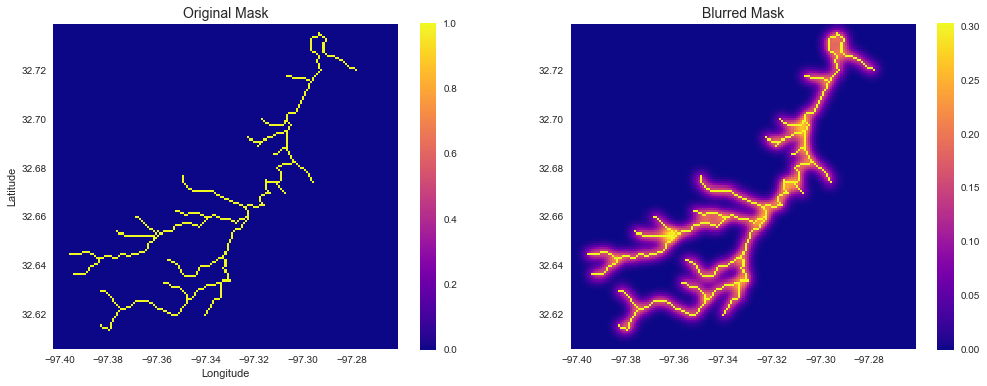

In [19]:
# Plot blurred mask
fig, ax = plt.subplots(1, 2, figsize=(17,6))
im0 = ax[0].imshow(mask.astype(float), cmap='plasma', zorder=1, extent=grid.extent)
im1 = ax[1].imshow(blurred_mask, cmap='plasma', zorder=1, extent=grid.extent)

plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])

ax[0].set_title('Original Mask', size=14)
ax[1].set_title('Blurred Mask', size=14)

ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')
ax[0].set_xlabel('Longitude')

In [20]:
# Set elevation change for burned cells
dz = 16.5

# Set mask to blurred mask
mask = blurred_mask

# Create a view onto the DEM array
dem = grid.view('dem', dtype=np.float64, nodata=np.nan)

# Subtract dz where mask is nonzero
dem[(mask > 0)] -= dz*mask[(mask > 0)]

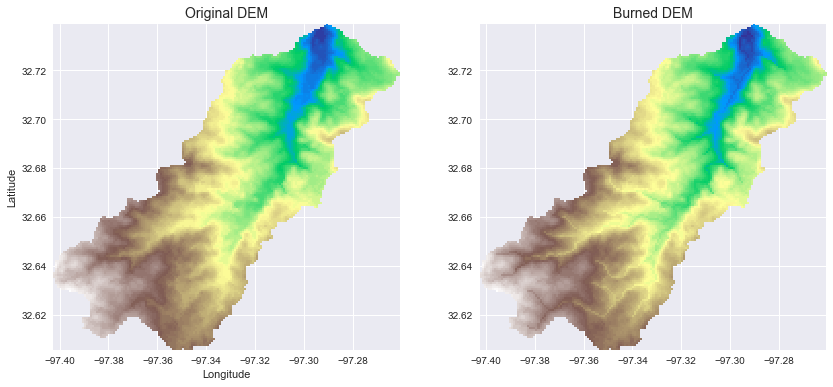

In [21]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].imshow(grid.view('dem', nodata=np.nan), cmap='terrain', zorder=1, extent=grid.extent)
ax[1].imshow(dem, cmap='terrain', zorder=1, extent=grid.extent)

ax[0].set_title('Original DEM', size=14)
ax[1].set_title('Burned DEM', size=14)

ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')
ax[0].set_xlabel('Longitude')